In [1]:
# Importing libraries for working with DataFrames and visualizations
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

# Importing the following for working with NILM dataset
from nilmtk.utils import print_dict
from nilmtk_contrib.disaggregate import Seq2Seq, Seq2Point
from nilmtk.api import API

plt.style.use('ggplot')

In [2]:
# Load model from pickle file
def import_model(filename):
    with open(filename, "rb") as pickle_in:
        model = pickle.load(pickle_in)
    return model

In [3]:
# Import the model
model = import_model('trained_models/1sec_99SL.pickle')

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2024-04-21 17:35:22         4710
metadata.json                                  2024-04-21 17:35:22           64
variables.h5                                   2024-04-21 17:35:22      5409952
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\conv1d
......vars
.........0
.........1
...layers\conv1d_1
......vars
.........0
.........1
...layers\conv1d_2
......vars
.........0
.........1
...layers\conv1d_3
......vars
.........0
.........1
...layers\conv1d_4
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\flatten
......vars
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10


In [31]:
# Function to get ground truth from model
def get_ground_truth(model):
    gt = {}
    for i in model.gt_overall.columns:
        gt[i] = model.gt_overall[i]
    return gt

# Function to plot different model's prediction vs ground truth
def plot_result(model):
    plt.rcParams['figure.figsize'] = [15, 10]

    for i in model.gt_overall.columns:
        plt.figure()
        # plt.plot(model.test_mains[0],label='Mains reading')
        # plt.plot(model.gt_overall[i],label='Truth')
        plt.plot(get_ground_truth(model)[i],label='Truth')
        for clf in model.pred_overall:
            plt.plot(model.pred_overall[clf][i],label=clf)
            plt.xticks(rotation=90)
        plt.title(i)
        plt.legend()
    plt.show()

In [59]:
# plot_result(model)
# model.test_submeters
get_ground_truth(model)

{'fridge': UNIX
 2022-11-08 10:39:23+08:00    0.0
 2022-11-08 10:39:24+08:00    0.0
 2022-11-08 10:39:25+08:00    0.0
 2022-11-08 10:39:26+08:00    0.0
 2022-11-08 10:39:27+08:00    0.0
                             ... 
 2022-11-08 17:46:17+08:00    0.0
 2022-11-08 17:46:18+08:00    0.0
 2022-11-08 17:46:19+08:00    0.0
 2022-11-08 17:46:20+08:00    0.0
 2022-11-08 17:46:21+08:00    0.0
 Freq: S, Name: fridge, Length: 25619, dtype: float32,
 'air conditioner': UNIX
 2022-11-08 10:39:23+08:00    0.0
 2022-11-08 10:39:24+08:00    0.0
 2022-11-08 10:39:25+08:00    0.0
 2022-11-08 10:39:26+08:00    0.0
 2022-11-08 10:39:27+08:00    0.0
                             ... 
 2022-11-08 17:46:17+08:00    0.0
 2022-11-08 17:46:18+08:00    0.0
 2022-11-08 17:46:19+08:00    0.0
 2022-11-08 17:46:20+08:00    0.0
 2022-11-08 17:46:21+08:00    0.0
 Freq: S, Name: air conditioner, Length: 25619, dtype: float32,
 'washing machine': UNIX
 2022-11-08 10:39:23+08:00    0.0
 2022-11-08 10:39:24+08:00    0.0

Loading data for  test  dataset
Dropping missing values
Generating predictions for : Seq2Seq
9/9 [==============================] - 0s 16ms/step
Generating predictions for : Seq2Point
9/9 [==============================] - 0s 41ms/step
............  mae  ..............
                                     Seq2Seq  Seq2SPoint
fridge                            234.482010  218.818069
air conditioner                   279.192017  267.688873
washing machine                   160.095612  193.292679
tumble dryer                      122.734253  121.635002
kettle                            178.419464   96.951042
vacuum cleaner                     31.634819   31.972042
electric water heating appliance  243.165588  166.934647
oven                               19.053043   19.274525
............  rmse  ..............
                                     Seq2Seq  Seq2SPoint
fridge                            425.389013  551.213831
air conditioner                   937.829375  902.763985
washing mac

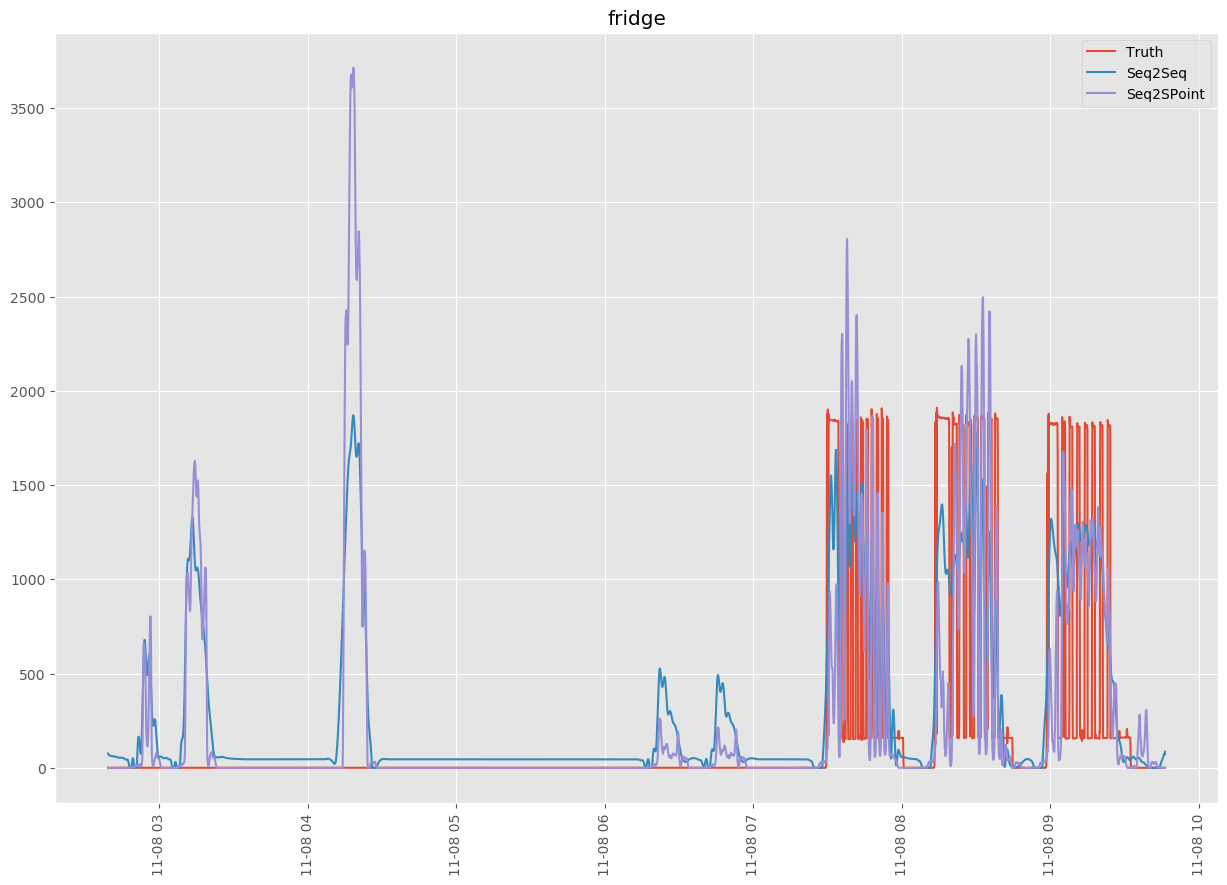

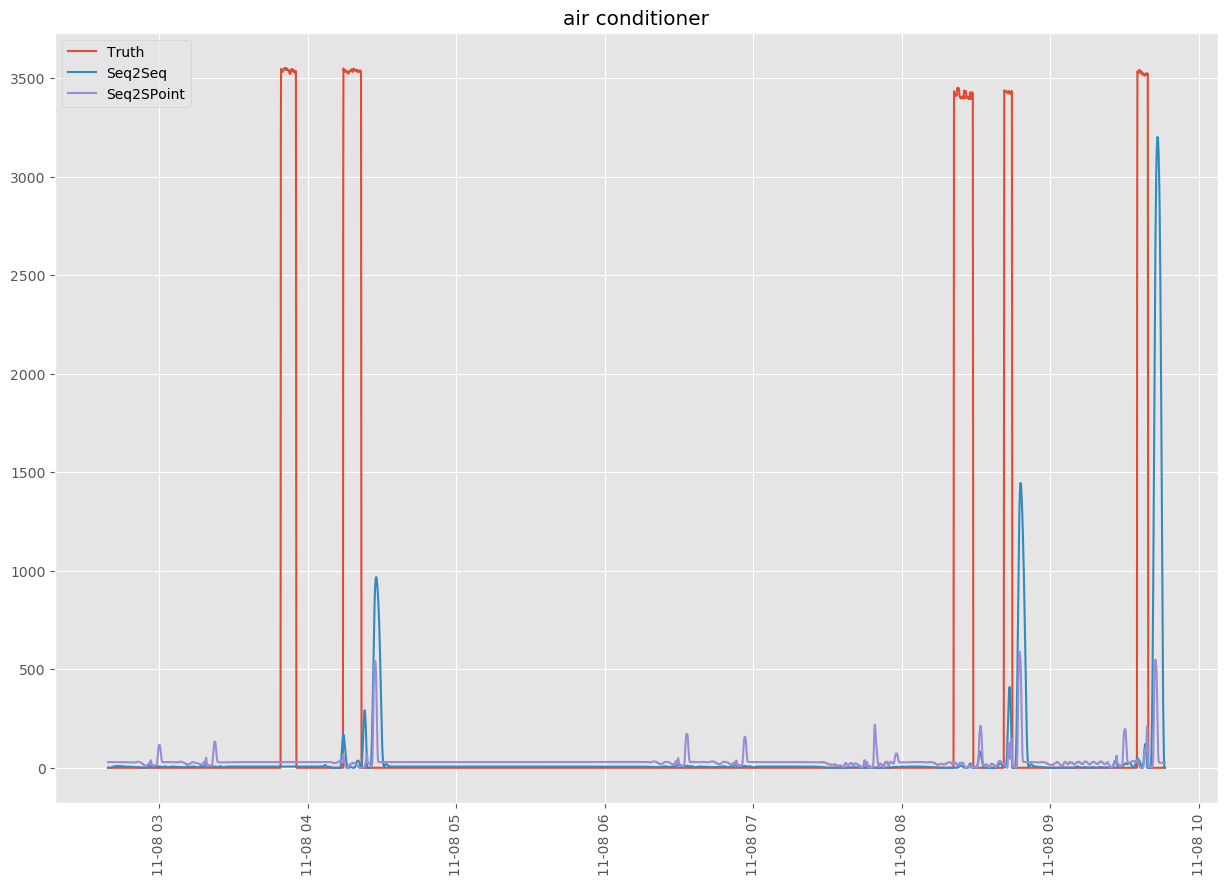

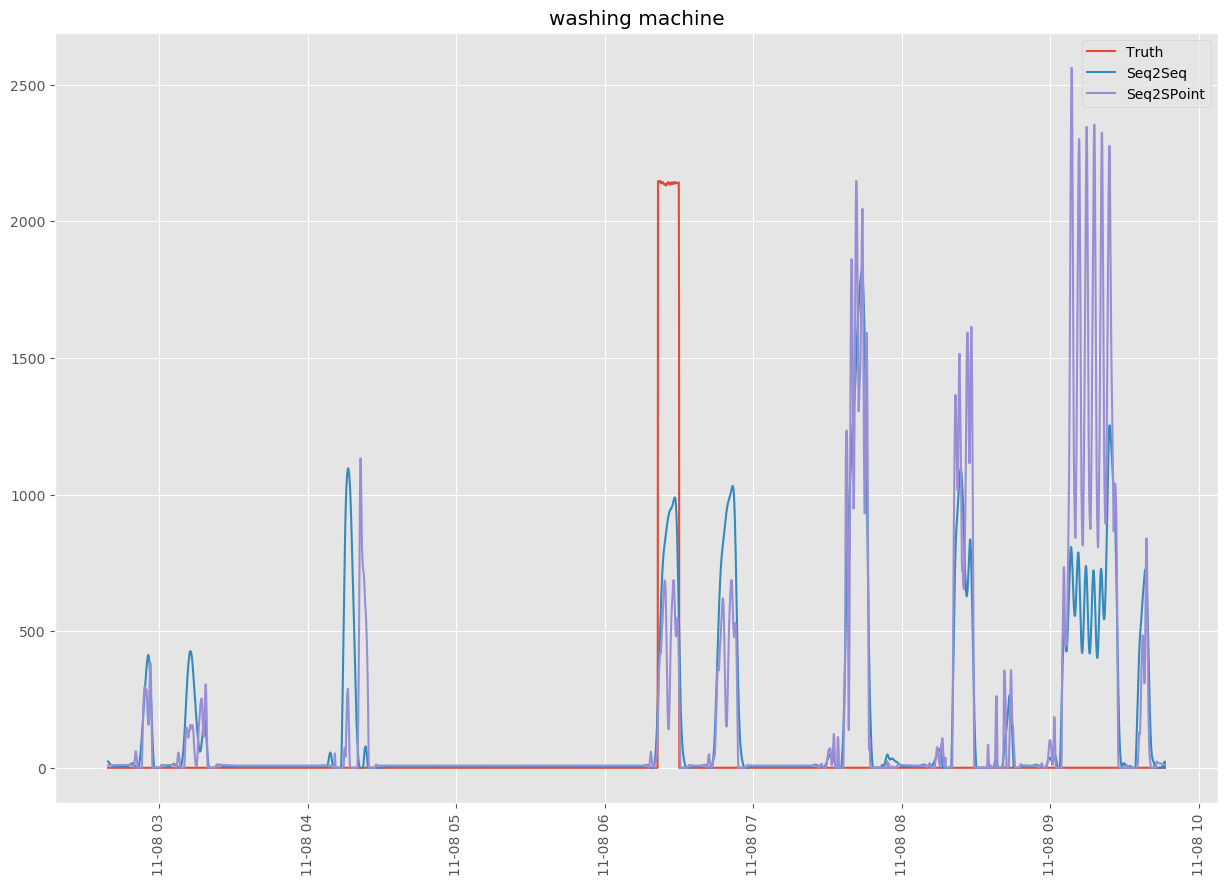

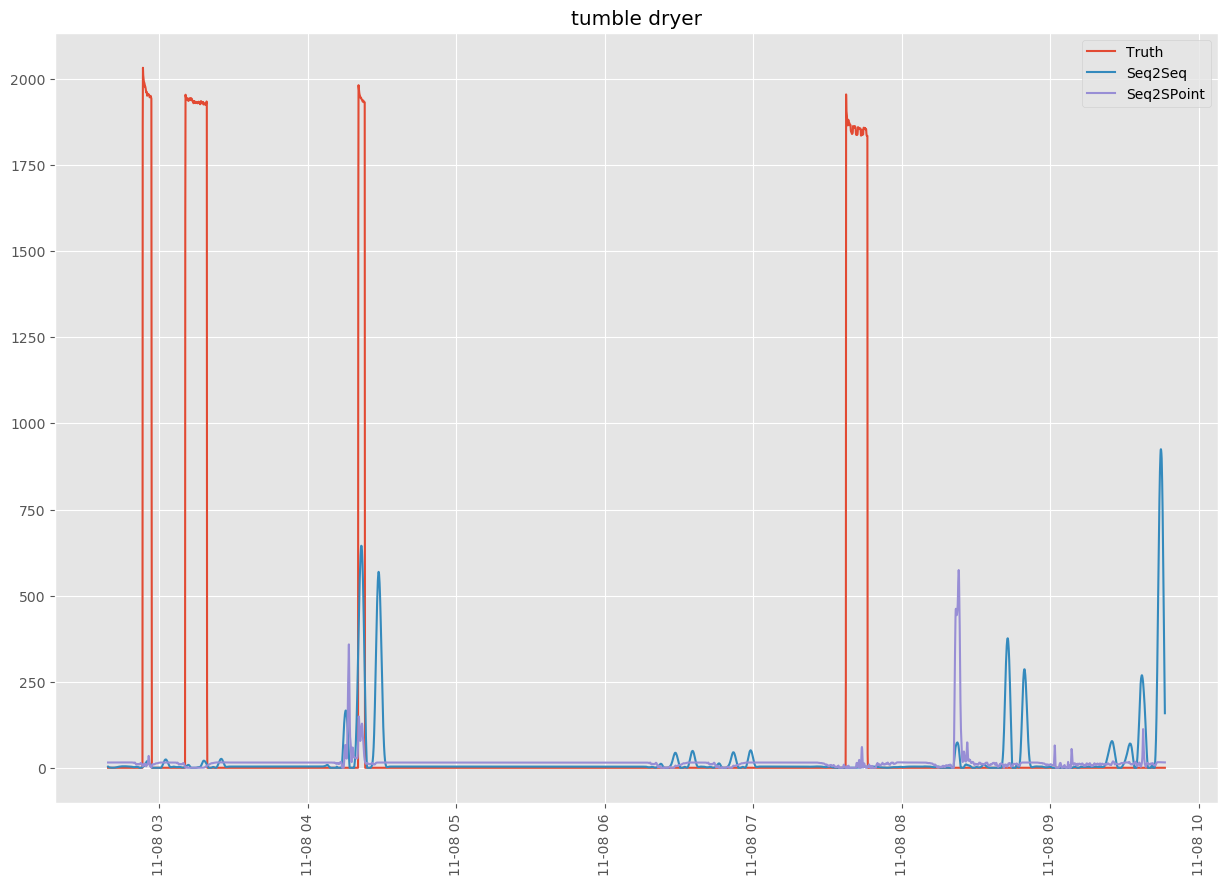

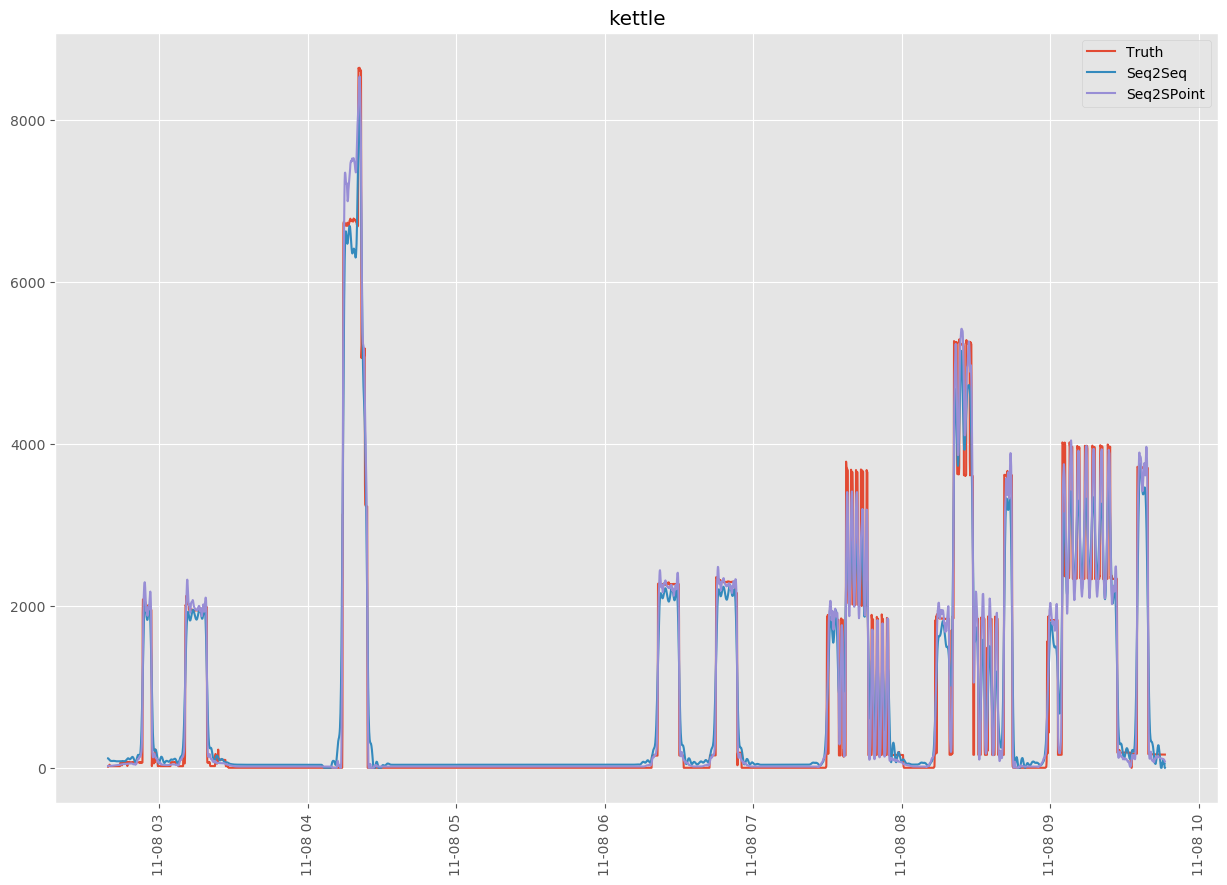

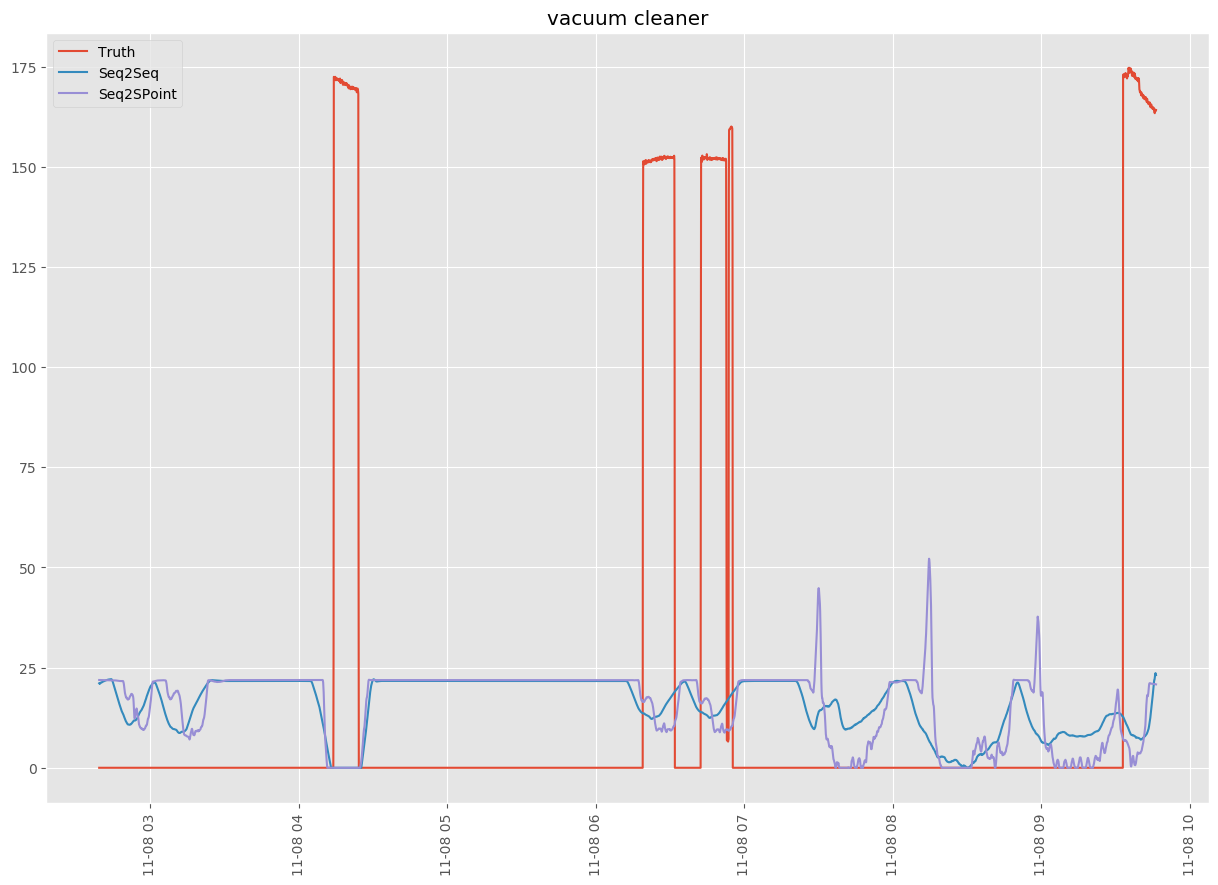

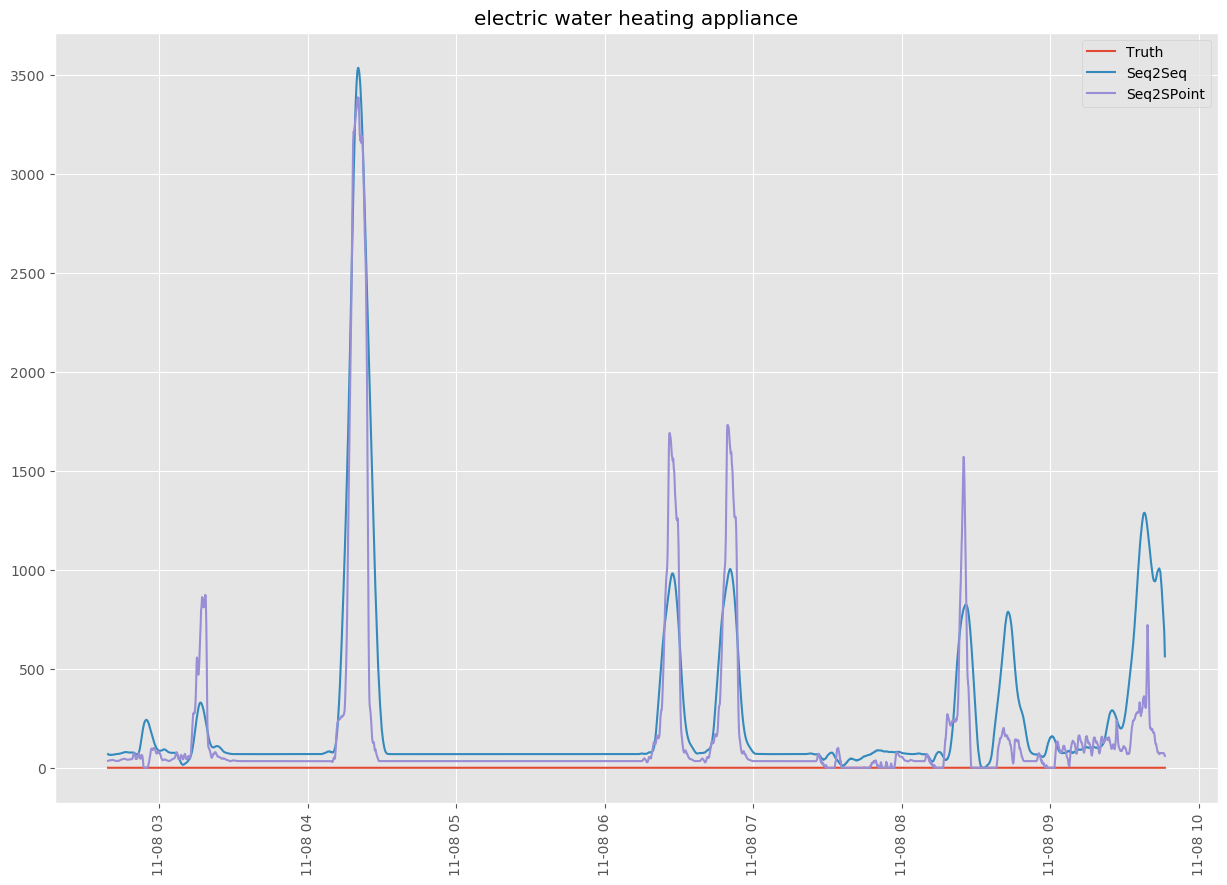

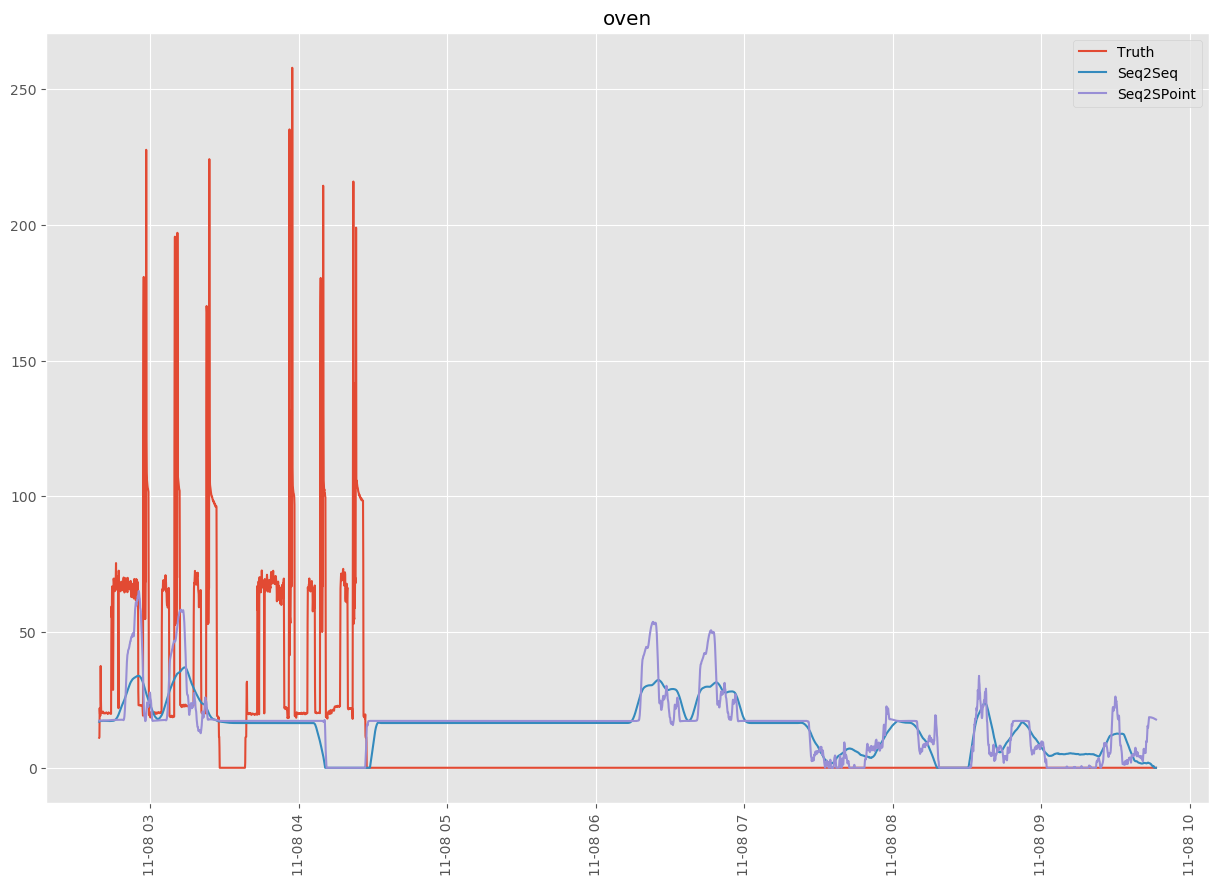

In [29]:
test_params = {
    'path': 'data/mimos_6_sec.h5',
    'buildings': {
        # 1: {
        #     'start_time': '2022-09-27',
        #     'end_time': '2022-09-28'
        # },
        # 2: {
        #     'start_time': '2022-09-29',
        #     'end_time': '2022-09-30'
        # },
        # 3: {
        #     'start_time': '2022-11-01',
        #     'end_time': '2022-11-02'
        # },
        # 4: {
        #     'start_time': '2022-11-07',
        #     'end_time': '2022-11-08'
        # },
        5: {
            'start_time': '2022-11-08',
            'end_time': '2022-11-09'
        },
        # 6: {
        #     'start_time': '2022-11-09',
        #     'end_time': '2022-11-10'
        # },
        # 7: {
        #     'start_time': '2022-11-10',
        #     'end_time': '2022-11-11'
        # }
    }
}

model.test_jointly({'test': test_params})